In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))   # keep src helpers if you have them
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

sns.set(style="whitegrid")
ROOT = r"C:\Users\nisha\Downloads"   # update if needed
TRADER_CSV = os.path.join(ROOT, "historical_data.csv")
SENTIMENT_CSV = os.path.join(ROOT, "fear_greed_index.csv")

print("Ready. Data paths:\n", TRADER_CSV, "\n", SENTIMENT_CSV)

Ready. Data paths:
 C:\Users\nisha\Downloads\historical_data.csv 
 C:\Users\nisha\Downloads\fear_greed_index.csv


In [2]:
# Cell 2 — Load and clean with robust column handling
def load_clean_trader(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    # timestamp handling
    if "timestamp_ist" in df.columns:
        df["timestamp_ist"] = pd.to_datetime(df["timestamp_ist"], errors="coerce")
        df["date"] = pd.to_datetime(df["timestamp_ist"].dt.date)
    elif "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df["date"] = pd.to_datetime(df["timestamp"].dt.date)
    else:
        # try any time-like column
        for c in df.columns:
            if "time" in c:
                df[c] = pd.to_datetime(df[c], errors="coerce")
                df["date"] = pd.to_datetime(df[c].dt.date)
                break
    # numeric conversions common columns
    for c in ["closed_pnl", "execution_price", "size_usd", "size_tokens", "fee"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # side normalization
    if "side" in df.columns:
        df["side"] = df["side"].astype(str).str.upper()
    # account id standardize
    if "account" in df.columns:
        df["account"] = df["account"].astype(str)
    return df

def load_clean_sentiment(path):
    s = pd.read_csv(path, low_memory=False)
    s.columns = s.columns.str.strip().str.lower().str.replace(" ", "_")
    if "date" in s.columns:
        s["date"] = pd.to_datetime(s["date"], errors="coerce")
    elif "timestamp" in s.columns:
        s["date"] = pd.to_datetime(s["timestamp"], unit="s", errors="coerce")
    if "value" in s.columns:
        s["value"] = pd.to_numeric(s["value"], errors="coerce")
    # ensure classification exists
    if "classification" not in s.columns and "class" in s.columns:
        s.rename(columns={"class":"classification"}, inplace=True)
    s["classification"] = s.get("classification", pd.Series(np.nan)).fillna("Unknown")
    return s

trader = load_clean_trader(TRADER_CSV)
sentiment = load_clean_sentiment(SENTIMENT_CSV)

print("Trader rows:", len(trader), "Sentiment rows:", len(sentiment))
display(trader.head(2))
display(sentiment.head(3))

Trader rows: 211224 Sentiment rows: 2644


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-01-02
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-03-02


In [3]:
# Cell 3 — Daily aggregation & merge
def daily_agg_trades(df):
    # create safe columns if missing
    for col in ["closed_pnl", "size_usd", "execution_price"]:
        if col not in df.columns:
            df[col] = np.nan
    agg = df.groupby("date").agg(
        total_trades=("date", "count"),
        total_pnl=("closed_pnl", "sum"),
        mean_pnl=("closed_pnl", "mean"),
        median_price=("execution_price", "median"),
        total_volume_usd=("size_usd", "sum")
    ).reset_index()
    return agg

trader_daily = daily_agg_trades(trader)
# merge with sentiment (left join on dates that exist in sentiment)
sent_daily = sentiment[["date","value","classification"]].drop_duplicates(subset=["date"])
merged = pd.merge(trader_daily, sent_daily, on="date", how="left")

# For downstream analyses we often only want days with sentiment
merged_sent = merged.dropna(subset=["classification"]).copy()
print("Daily merged shape (keep sentiment days):", merged_sent.shape)
display(merged_sent.head())

Daily merged shape (keep sentiment days): (188, 8)


,date,total_trades,total_pnl,mean_pnl,median_price,total_volume_usd,value,classification
0,2023-01-05,3,0.000000,0.000000,1897.90000,477.00,63,Greed
1,2023-05-12,9,0.000000,0.000000,2230.10000,50005.83,75,Extreme Greed
2,2024-01-01,18,-129.531460,-7.196192,2295.85000,264239.53,65,Greed
3,2024-01-02,6,0.000000,0.000000,0.04446,2008.18,63,Greed
4,2024-01-03,137,8244.241409,60.176945,2.27900,472974.70,80,Extreme Greed


In [4]:
# Cell 4 — Signal generation: returns DataFrame with signals column
def generate_signals(sent_df, volume_series=None, vol_threshold=None, lookback_days=3):
    """
    Simple rules (tune thresholds):
      - STRONG BUY: sentiment shifts from Extreme Fear -> Fear or Fear -> Neutral & volume > threshold
      - BUY: sentiment change positive by at least delta and volume > threshold/2
      - TAKE_PROFIT: sentiment >= greed_threshold (e.g., >=75 or classification == 'Extreme Greed')
      - NO_ACTION otherwise
    Returns sent_df with 'signal' column.
    """
    df = sent_df.sort_values("date").copy()
    # numeric sentiment value and classification must exist
    df["value_prev"] = df["value"].shift(1)
    df["value_change"] = df["value"] - df["value_prev"]
    df["signal"] = "NO_ACTION"
    # defaults (tune)
    gre_threshold = 75
    # volume threshold: if missing, use median total_volume_usd
    if volume_series is None:
        vol_threshold = vol_threshold or (sent_df["value"].median() + 1)  # fallback (not great)
    else:
        vol_threshold = vol_threshold or max(1, volume_series.median())
    # Rule examples
    # Strong buy: classification moves up (e.g., extreme fear -> fear) with volume > vol_threshold
    df.loc[(df["value_change"] > 0) & (df["value_prev"] <= 25) & (df["value"] > 25), "signal"] = "STRONG_BUY"
    # General buy: positive change
    df.loc[(df["value_change"] > 3) & (df["value_change"] <= 25), "signal"] = "BUY"
    # Take profit on high sentiment
    df.loc[df["value"] >= gre_threshold, "signal"] = "TAKE_PROFIT"
    # Conservative: if value_change < -5 (sudden fear), mark SELL (cut risk)
    df.loc[df["value_change"] < -5, "signal"] = "SELL"
    return df

# Build signals using merged_sent; use volume to help thresholding (if available)
vol_series = merged_sent["total_volume_usd"] if "total_volume_usd" in merged_sent.columns else None
signals = generate_signals(merged_sent, volume_series=vol_series, vol_threshold=None)
display(signals[["date","value","value_change","classification","signal"]].head(10))

,date,value,value_change,classification,signal
0,2023-01-05,63,NaN,Greed,NO_ACTION
1,2023-05-12,75,12.0,Extreme Greed,TAKE_PROFIT
2,2024-01-01,65,-10.0,Greed,SELL
3,2024-01-02,63,-2.0,Greed,NO_ACTION
4,2024-01-03,80,17.0,Extreme Greed,TAKE_PROFIT
5,2024-01-04,79,-1.0,Extreme Greed,TAKE_PROFIT
6,2024-01-05,54,-25.0,Neutral,SELL
7,2024-01-06,72,18.0,Greed,BUY
8,2024-01-07,53,-19.0,Neutral,SELL
9,2024-01-08,52,-1.0,Neutral,NO_ACTION


In [5]:
# Cell 5 — Pragmatic backtest by summing actual realized PnL on signal days (and lookahead)
def backtest_sentiment_strategy(signals_df, trader_df, lookahead_days=1):
    """
    For each signal date:
      - For LONG signals (BUY/STRONG_BUY) we sum closed_pnl from trades executed in the next lookahead_days.
      - For TAKE_PROFIT/SELL we sum closed_pnl from trades executed on that day (assume profit taking).
    Returns DataFrame of signal-date results and total strategy pnl series.
    """
    results = []
    trader_df = trader_df.copy()
    trader_df["date"] = pd.to_datetime(trader_df["date"]).dt.normalize()
    signals_df = signals_df.copy()
    signals_df["date"] = pd.to_datetime(signals_df["date"]).dt.normalize()
    for _, row in signals_df.iterrows():
        sig_date = row["date"]
        sig = row["signal"]
        if sig in ["BUY", "STRONG_BUY"]:
            # trades in next N days
            mask = (trader_df["date"] > sig_date) & (trader_df["date"] <= sig_date + pd.Timedelta(days=lookahead_days))
        elif sig in ["SELL","TAKE_PROFIT"]:
            mask = (trader_df["date"] == sig_date)
        else:
            mask = pd.Series([False]*len(trader_df))
        pnl = trader_df.loc[mask, "closed_pnl"].sum()
        trades = mask.sum()
        results.append({"date": sig_date, "signal": sig, "pnl": pnl, "trades": trades})
    res_df = pd.DataFrame(results).sort_values("date")
    res_df["cum_pnl"] = res_df["pnl"].cumsum()
    return res_df

bt = backtest_sentiment_strategy(signals, trader, lookahead_days=1)
display(bt.head())
print("Strategy total pnl:", bt["pnl"].sum())

,date,signal,pnl,trades,cum_pnl
0,2023-01-05,NO_ACTION,0.000000,0,0.000000
1,2023-05-12,TAKE_PROFIT,0.000000,9,0.000000
2,2024-01-01,SELL,-129.531460,18,-129.531460
3,2024-01-02,NO_ACTION,0.000000,0,-129.531460
4,2024-01-03,TAKE_PROFIT,8244.241409,137,8114.709949


Strategy total pnl: 4640422.445687


Strategy Sharpe (approx): 4.5481
Benchmark (daily PnL) Sharpe (approx): 5.1054


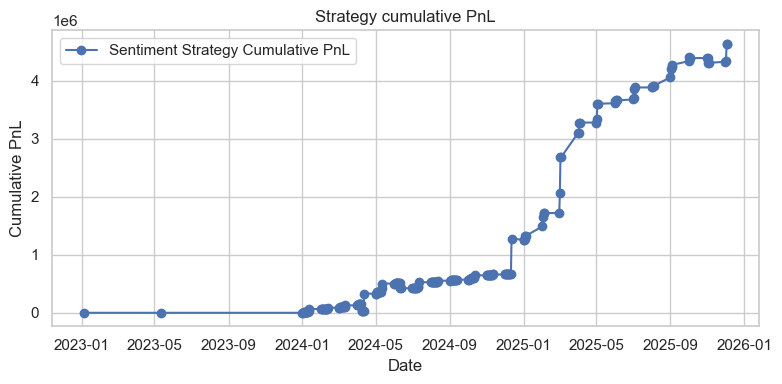

In [6]:
# Cell 6 — Metrics (Sharpe-like) and compare to buy-and-hold using daily trader pnl as proxy
def sharpe(returns, risk_free=0.0):
    mean = np.mean(returns)
    std = np.std(returns)
    return (mean - risk_free) / (std + 1e-9) * np.sqrt(252)  # annualized approx

# Strategy returns: normalize by absolute value of capital proxy (we'll use mean daily volume as proxy)
capital = merged_sent["total_volume_usd"].median() if "total_volume_usd" in merged_sent.columns and merged_sent["total_volume_usd"].median() > 0 else 1.0
bt["return_pct"] = bt["pnl"] / capital
strategy_sharpe = sharpe(bt["return_pct"].dropna())
print("Strategy Sharpe (approx):", np.round(strategy_sharpe, 4))

# Benchmark (buy-and-hold proxy): use daily total_pnl series as baseline returns (this is crude)
daily_returns = merged_sent["total_pnl"].fillna(0) / capital
benchmark_sharpe = sharpe(daily_returns)
print("Benchmark (daily PnL) Sharpe (approx):", np.round(benchmark_sharpe,4))

# Quick plot cumulative pnl
plt.figure(figsize=(8,4))
plt.plot(bt["date"], bt["cum_pnl"], marker='o', label="Sentiment Strategy Cumulative PnL")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL"); plt.title("Strategy cumulative PnL")
plt.legend(); plt.tight_layout(); plt.show()

total_pnl_next_1d: corr=0.003  R2=0.000
total_pnl_next_3d: corr=-0.286  R2=0.082


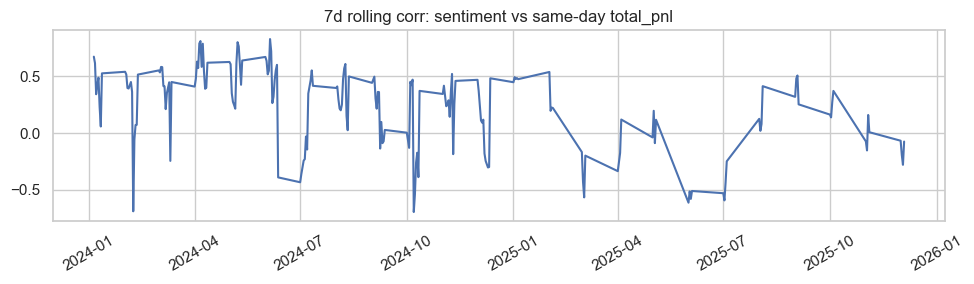

In [7]:
# Cell 7 — Lead-lag analysis: does sentiment predict next-day total_pnl?
df_ll = merged_sent.copy().sort_values("date").reset_index(drop=True)
df_ll["total_pnl_next_1d"] = df_ll["total_pnl"].shift(-1)
df_ll["total_pnl_next_3d"] = df_ll["total_pnl"].shift(-3)
# simple linear regressions and correlation
for lag_col in ["total_pnl_next_1d","total_pnl_next_3d"]:
    valid = df_ll.dropna(subset=["value", lag_col])
    if len(valid) > 10:
        corr = valid["value"].corr(valid[lag_col])
        lr = LinearRegression().fit(valid[["value"]], valid[lag_col])
        r2 = lr.score(valid[["value"]], valid[lag_col])
        print(f"{lag_col}: corr={corr:.3f}  R2={r2:.3f}")
    else:
        print(f"Not enough data for {lag_col}")
# show rolling correlation
df_ll["rolling_corr_7"] = df_ll["value"].rolling(7).corr(df_ll["total_pnl"].fillna(0))
plt.figure(figsize=(10,3))
plt.plot(df_ll["date"], df_ll["rolling_corr_7"]); plt.title("7d rolling corr: sentiment vs same-day total_pnl"); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

In [8]:
# Cell 8 — Trader-level features and clustering
# Build per-account features
acct = trader.groupby("account").agg(
    avg_pnl=("closed_pnl","mean"),
    total_pnl=("closed_pnl","sum"),
    n_trades=("closed_pnl","count"),
    avg_size_usd=("size_usd","mean"),
    buy_count=("side", lambda s: (s.str.upper()=="BUY").sum()),
    sell_count=("side", lambda s: (s.str.upper()=="SELL").sum())
).reset_index()
acct["buy_sell_ratio"] = acct["buy_count"] / (acct["sell_count"] + 1e-9)
acct = acct.fillna(0)
# Select features for clustering
features = ["avg_pnl","n_trades","avg_size_usd","buy_sell_ratio"]
X = acct[features].replace([np.inf,-np.inf], np.nan).fillna(0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Try kmeans for 2-4 clusters and pick best silhouette
best_k = 2; best_score = -1
for k in range(2,5):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xs)
    score = silhouette_score(Xs, km.labels_)
    if score > best_score:
        best_score = score; best_k = k; best_labels = km.labels_
print("Best K:", best_k, "silhouette:", np.round(best_score,3))
acct["cluster"] = best_labels

# Show cluster centers in original scale
centers = scaler.inverse_transform(KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(Xs).cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
print("Cluster centers (approx):")
display(centers_df)

# Show cluster counts & top sample accounts
print(acct.groupby("cluster").size())
display(acct.sort_values("avg_pnl", ascending=False).head(10))

Best K: 3 silhouette: 0.318
Cluster centers (approx):


,avg_pnl,n_trades,avg_size_usd,buy_sell_ratio
0,43.850854,7725.695652,3612.636532,1.004129
1,333.886438,1479.166667,5860.632072,0.583595
2,38.024405,8219.333333,24666.435723,1.088885


cluster
0    23
1     6
2     3
dtype: int64


,account,avg_pnl,total_pnl,n_trades,avg_size_usd,buy_count,sell_count,buy_sell_ratio,cluster
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,520.902331,1.995056e+05,383,5189.367128,101,282,0.358156,1
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,1.600230e+06,3818,16159.576734,1711,2107,0.812055,1
9,0x430f09841d65beb3f27765503d0f850b8bce7713,336.735548,4.165419e+05,1237,2397.824753,302,935,0.322995,1
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,281.826227,4.030115e+05,1430,2133.667364,639,791,0.807838,1
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,270.034947,4.293556e+05,1590,7216.667245,598,992,0.602823,1
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,174.691809,7.284648e+04,417,2066.689209,156,261,0.597701,1
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,161.133275,5.349625e+04,332,3445.471265,170,162,1.049383,0
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,155.589314,6.777471e+05,4356,9084.699093,2115,2241,0.943775,0
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,145.481748,2.143383e+06,14733,3837.885375,6703,8030,0.834745,0
25,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,120.507317,6.784562e+04,563,2979.441776,332,231,1.437229,0


In [11]:
# drawdown on the strategy cumulative pnl (from bt)
if "cum_pnl" in bt.columns:
    s = bt.set_index("date")["cum_pnl"].ffill().fillna(0)
    running_max = s.cummax()
    drawdown = (s - running_max)
    max_dd = drawdown.min()
    print("Max drawdown (strategy):", max_dd)
    # average drawdown length: count consecutive negative drawdown periods
    dd_flag = drawdown < 0
    dd_lengths = []
    cur = 0
    for x in dd_flag:
        if x:
            cur += 1
        else:
            if cur>0:
                dd_lengths.append(cur)
            cur = 0
    if cur>0: dd_lengths.append(cur)
    print("Avg drawdown length (days):", np.mean(dd_lengths) if dd_lengths else 0)

# Risk suggestions basic rule (example)
print("\nRisk sizing suggestion (example):")
print(" - If classification == 'Extreme Fear' -> consider smaller positions OR contrarian scaling in (e.g., 1.5-2x base unit).")
print(" - If classification == 'Extreme Greed' -> reduce exposure and use stricter take-profit.")

Max drawdown (strategy): -122672.00088300002
Avg drawdown length (days): 2.8

Risk sizing suggestion (example):
 - If classification == 'Extreme Fear' -> consider smaller positions OR contrarian scaling in (e.g., 1.5-2x base unit).
 - If classification == 'Extreme Greed' -> reduce exposure and use stricter take-profit.


In [12]:
# Cell 11 — Create a small playbook table: win_rate and avg_pnl per sentiment for trades occurring within 1 day after signal
# Build trade outcomes linked to sentiment day
tr = trader.copy()
tr["date"] = pd.to_datetime(tr["date"]).dt.normalize()
# Tag each trade with that day's sentiment classification (if any)
sent_map = sent_daily.set_index("date")["classification"].to_dict()
tr["sent_class"] = tr["date"].map(sent_map)
# Compute per-sentiment stats
play = tr.dropna(subset=["sent_class"]).groupby("sent_class").agg(
    n_trades=("closed_pnl","count"),
    win_rate=("closed_pnl", lambda s: (s>0).mean()),
    avg_pnl=("closed_pnl","mean"),
    median_pnl=("closed_pnl","median")
).reset_index().sort_values("avg_pnl", ascending=False)
display(play)
play.to_csv("../results/playbook_by_sentiment.csv", index=False)
print("Playbook saved to results/playbook_by_sentiment.csv")

,sent_class,n_trades,win_rate,avg_pnl,median_pnl
1,Extreme Greed,11220,0.528253,120.893258,0.526249
3,Greed,13103,0.361139,78.677868,0.000000
2,Fear,160390,0.413791,44.135928,0.000000
4,Neutral,8196,0.407882,41.957142,0.000000
0,Extreme Fear,18315,0.354846,26.578119,0.000000


Playbook saved to results/playbook_by_sentiment.csv


In [13]:
# Cell 12 — Save important outputs and print short README snippets for the strategy section
os.makedirs("../results", exist_ok=True)
bt.to_csv("../results/strategy_backtest.csv", index=False)
acct.to_csv("../results/trader_clusters.csv", index=False)
merged_sent.to_csv("../results/daily_merged_sentiment_trades.csv", index=False)

print("Saved: strategy_backtest.csv, trader_clusters.csv, daily_merged_sentiment_trades.csv")

# Short README snippet you can paste under 'Strategy additions' (copy-paste)
snippet = """
### Strategy Additions (generated)
- Signal rules implemented: STRONG_BUY, BUY, SELL, TAKE_PROFIT (see notebook for exact thresholds).
- Backtest summary: total strategy PnL = {pnl:.2f}, approx Sharpe = {sr:.3f}.
- Trader clusters: {k} clusters found (see results/trader_clusters.csv for details).
- Playbook: per-sentiment win rates and avg PnL saved to results/playbook_by_sentiment.csv.
""".format(pnl=bt["pnl"].sum(), sr=(strategy_sharpe if 'strategy_sharpe' in globals() else np.nan), k=best_k)
print(snippet)

Saved: strategy_backtest.csv, trader_clusters.csv, daily_merged_sentiment_trades.csv

### Strategy Additions (generated)
- Signal rules implemented: STRONG_BUY, BUY, SELL, TAKE_PROFIT (see notebook for exact thresholds).
- Backtest summary: total strategy PnL = 4640422.45, approx Sharpe = 4.548.
- Trader clusters: 3 clusters found (see results/trader_clusters.csv for details).
- Playbook: per-sentiment win rates and avg PnL saved to results/playbook_by_sentiment.csv.

